## PART3
## Question 2 (e,f)(weka)

#### (e) Model Trees 
##### One can use scikit learn to call Weka to train Logistic Model Trees for classiﬁcation. Train Logistic Model Trees for the APS data set without compensation for class imbalance. Use one of 5 fold, 10 fold, and leave-one-out cross validation methods to estimate the error of your trained model and compare it with the test error. Report the Confusion Matrix, ROC, and AUC for training and test sets.

##### Answer:
##### I choose 5-fold cv, the cv error is 0.85% ,the train error is 0.3067%, the test error is 0.8688%. The confusion matrix, roc and auc is reported below.

In [1]:
# load the data and packages
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, RocCurveDisplay, accuracy_score
import warnings
warnings.filterwarnings("ignore")

data_test = pd.read_csv('../data/aps_failure_test_set.csv', skiprows=19, sep=",", na_values=["na"])
data_train = pd.read_csv('../data/aps_failure_training_set.csv', skiprows=19, sep=",", na_values=["na"])

In [2]:
# for saving time, if we can find knn_x_csv in the dir, we ignore the imputation.
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer, SimpleImputer, KNNImputer

data = data_train.append(data_test)

if os.path.isfile("knn_x.csv"):
    df_knn_x = pd.read_csv('knn_x.csv')
else:
    features_name = data_train.iloc[:,1:].columns.tolist()
    imp_knn = KNNImputer(missing_values=np.nan)
    data_knn_x = imp_knn.fit_transform(data.iloc[:,1:])
    df_knn_x = pd.DataFrame(data_knn_x, columns = features_name)
    df_knn_x.to_csv("knn_x.csv",index=0)
    
    

In [3]:
y_train = data_train['class']
y_test = data_test['class']

knn_x_train = df_knn_x.iloc[0:60000,:]
knn_x_test = df_knn_x.iloc[60000:,:]

In [4]:
import javabridge
import weka.core.jvm as jvm
jvm.start(packages=True)

import weka.core.packages as packages
from weka.classifiers import FilteredClassifier
from weka.core.dataset import create_instances_from_matrices
from weka.classifiers import Classifier
from weka.filters import Filter
from weka.classifiers import Evaluation
from weka.core.classes import Random
import weka.plot.classifiers as plcls  

packages.install_package("SMOTE")

DEBUG:weka.core.jvm:Adding bundled jars
DEBUG:weka.core.jvm:Classpath=['/Users/qian/opt/anaconda3/envs/tensorflow/lib/python3.8/site-packages/javabridge/jars/rhino-1.7R4.jar', '/Users/qian/opt/anaconda3/envs/tensorflow/lib/python3.8/site-packages/javabridge/jars/runnablequeue.jar', '/Users/qian/opt/anaconda3/envs/tensorflow/lib/python3.8/site-packages/javabridge/jars/cpython.jar', '/Users/qian/opt/anaconda3/envs/tensorflow/lib/python3.8/site-packages/weka/lib/python-weka-wrapper.jar', '/Users/qian/opt/anaconda3/envs/tensorflow/lib/python3.8/site-packages/weka/lib/weka.jar']
DEBUG:weka.core.jvm:MaxHeapSize=default
DEBUG:weka.core.jvm:Package support enabled


True

In [5]:
x_train_weka = knn_x_train.values
x_test_weka = knn_x_test.values

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(["neg", "pos"])
y_train_weka2 = le.transform(y_train)
y_test_weka2 = le.transform(y_test)

In [6]:
dataset_train = create_instances_from_matrices(x_train_weka, y_train_weka2, name="train data")
dataset_test = create_instances_from_matrices(x_test_weka, y_test_weka2, name="test data")

dataset_train.class_is_last()
dataset_test.class_is_last()

In [7]:
num_to_nom = Filter(classname="weka.filters.unsupervised.attribute.NumericToNominal", options=["-R", "last"])
num_to_nom.inputformat(dataset_train)    #data is the weka dataset whose last column is numeric.

train_data =num_to_nom.filter(dataset_train)   #newData is the weka dataset whose last column is nominal.
test_data =num_to_nom.filter(dataset_test)

In [8]:
from weka.classifiers import Classifier
cls = Classifier(classname="weka.classifiers.trees.LMT")

cls.build_classifier(train_data)


This is the train data result:

Correctly Classified Instances       59816               99.6933 %
Incorrectly Classified Instances       184                0.3067 %
Kappa statistic                          0.8992
Mean absolute error                      0.0059
Root mean squared error                  0.0527
Relative absolute error                 17.9881 %
Root relative squared error             41.1861 %
Total Number of Instances            60000     



,predicted neg,predicted pos
neg,58981.0,19.0
pos,165.0,835.0


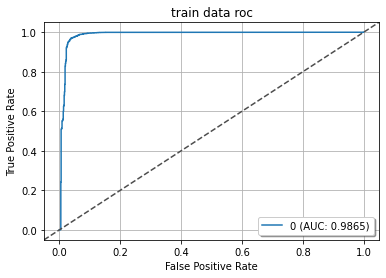

This is the test data result:

Correctly Classified Instances       15861               99.1312 %
Incorrectly Classified Instances       139                0.8688 %
Kappa statistic                          0.7903
Mean absolute error                      0.011 
Root mean squared error                  0.0875
Relative absolute error                 27.9503 %
Root relative squared error             57.7991 %
Total Number of Instances            16000     



,predicted neg,predicted pos
neg,15592.0,33.0
pos,106.0,269.0


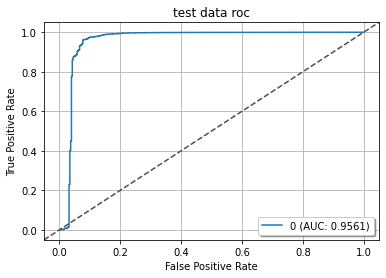

In [9]:
# evaluate model on train and test set
print("This is the train data result:")
evl_train = Evaluation(train_data)
y_predict_train = evl_train.test_model(cls, train_data)
print(evl_train.summary())
cm_df_weka_train = pd.DataFrame(evl_train.confusion_matrix, columns=["predicted neg","predicted pos"], index=["neg", "pos"])
display(cm_df_weka_train)
plcls.plot_roc(evl_train, title="train data roc", wait=True)



print("This is the test data result:")
evl_test = Evaluation(train_data)
y_predict_test = evl_test.test_model(cls, test_data)
print(evl_test.summary())
cm_df_weka_test = pd.DataFrame(evl_test.confusion_matrix, columns=["predicted neg","predicted pos"], index=["neg", "pos"])
display(cm_df_weka_test)
plcls.plot_roc(evl_test, title="test data roc", wait=True)

In [10]:
# for cv
evl_cv1 = Evaluation(train_data)
evl_cv1.crossvalidate_model(cls, train_data, 5, Random(1))

In [11]:
print(evl_cv1.percent_correct)
print(evl_cv1.summary())

99.15

Correctly Classified Instances       59490               99.15   %
Incorrectly Classified Instances       510                0.85   %
Kappa statistic                          0.7206
Mean absolute error                      0.0117
Root mean squared error                  0.0841
Relative absolute error                 35.8111 %
Root relative squared error             65.7008 %
Total Number of Instances            60000     



#### (f) Use SMOTE (Synthetic Minority Over-sampling Technique) to pre-process your data to compensate for class imbalance. Train a Logistic Model Tree using the pre-processed data and repeat 2e. Do not forget that there is a right and a wrong way of cross validation here. Compare the uncompensated case with SMOTE.

#### ANSWER:
#### The cv error rate with smote is 0.8567 %, train error rate is 0.3167% , test error rate is 1.0063 %
#### we can find in test data in 2e and 2f, the false negative number has decreased from 106 to 101...

In [12]:
# Use Smote

# cv
SMOTE = Filter(classname="weka.filters.supervised.instance.SMOTE")

fc = FilteredClassifier()
fc.filter = SMOTE
fc.classifier = cls

evl_smote_cv = Evaluation(train_data)
evl_smote_cv.crossvalidate_model(fc, train_data, 5, Random(1))

print(evl_smote_cv.percent_correct)
print(evl_smote_cv.summary())


99.14333333333333

Correctly Classified Instances       59486               99.1433 %
Incorrectly Classified Instances       514                0.8567 %
Kappa statistic                          0.7323
Mean absolute error                      0.0126
Root mean squared error                  0.0853
Relative absolute error                 38.4489 %
Root relative squared error             66.6417 %
Total Number of Instances            60000     



In [13]:
cm_smote_cv = pd.DataFrame(evl_smote_cv.confusion_matrix, columns=["predicted neg","predicted pos"], index=["neg", "pos"])
display(cm_smote_cv)

,predicted neg,predicted pos
neg,58767.0,233.0
pos,281.0,719.0


In [14]:
fc.build_classifier(train_data)

This is the train data with smote result:

Correctly Classified Instances       59810               99.6833 %
Incorrectly Classified Instances       190                0.3167 %
Kappa statistic                          0.8988
Mean absolute error                      0.0069
Root mean squared error                  0.0537
Relative absolute error                 20.9706 %
Root relative squared error             41.9079 %
Total Number of Instances            60000     



,predicted neg,predicted pos
neg,58951.0,49.0
pos,141.0,859.0


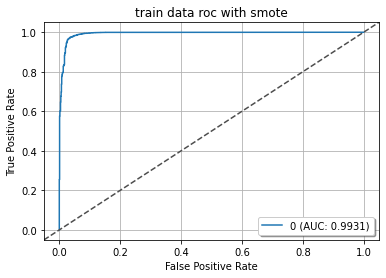

This is the test data with smote result:

Correctly Classified Instances       15839               98.9938 %
Incorrectly Classified Instances       161                1.0063 %
Kappa statistic                          0.7678
Mean absolute error                      0.013 
Root mean squared error                  0.0946
Relative absolute error                 33.1121 %
Root relative squared error             62.4626 %
Total Number of Instances            16000     



,predicted neg,predicted pos
neg,15565.0,60.0
pos,101.0,274.0


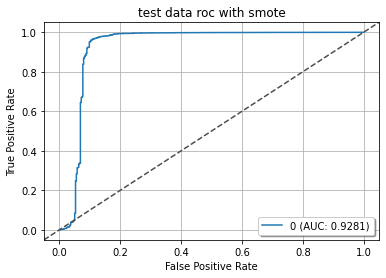

In [15]:
# evaluate model on train and test set
print("This is the train data with smote result:")
evl_smote_train = Evaluation(train_data)
y_predict_train2 = evl_smote_train.test_model(fc, train_data)
print(evl_smote_train.summary())
cm_df_weka_train2 = pd.DataFrame(evl_smote_train.confusion_matrix, columns=["predicted neg","predicted pos"], index=["neg", "pos"])
display(cm_df_weka_train2)
plcls.plot_roc(evl_smote_train, title="train data roc with smote", wait=True)



print("This is the test data with smote result:")
evl_smote_test = Evaluation(train_data)
y_predict_test2 = evl_smote_test.test_model(fc, test_data)
print(evl_smote_test.summary())
cm_df_weka_test2 = pd.DataFrame(evl_smote_test.confusion_matrix, columns=["predicted neg","predicted pos"], index=["neg", "pos"])
display(cm_df_weka_test2)
plcls.plot_roc(evl_smote_test, title="test data roc with smote", wait=True)